In [1]:
import os
import sys
import ast
import glob
import h5py
import numpy as np
import pandas as pd
import concurrent.futures
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as colors
from importlib import reload
import matplotlib.cm as cm
from copy import deepcopy
%matplotlib inline

In [2]:
sys.path.append("/home/terliuk/XENONscripts/WFsim_pattern_gen/")
from plot_patterns import plot_one_array, plot_pattern

In [3]:
config = "A_const_100__Z_const_-1"
nevents = 10000 # this identifies files
nfiles = 50 # and number of files to read

infolder = "/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/%s/"%config
allfiles = glob.glob(infolder+"WFsim_%s_N%d_*.hdf5"%(config, nevents))
allfiles.sort()
positions = np.zeros((0,3))
patterns = np.zeros((0,494))
for onefname in allfiles[0:nfiles]:
    print(onefname)
    onefile = h5py.File(onefname,"r")
    patterns = np.concatenate([patterns, np.array(onefile['area_per_channel'])])
    positions = np.concatenate([positions, np.array(onefile['corr_pos'])])
positions = positions*10. # converting to mm

/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000000.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000001.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000002.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000003.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000004.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000005.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_100__Z_const_-1/WFsim_A_const_100__Z_const_-1_N10000_000006.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patter

In [4]:
pmtpos = pickle.load(open("/project2/lgrandi/terliuk/PMTpositions.pckl","rb")) 
n_PMT_top=np.sum(pmtpos['array']=="top")

In [5]:
norm = "maxnorm"
transformation = "dw"

sys.path.append("/home/terliuk/XENONscripts/CNN_posrec/")
import PatternConverter
from HexLayers import ConvHex
converter = PatternConverter.PatternConverter(model =transformation)

In [6]:
patterns_all = [None] * patterns.shape[0]
for iev in range(0, patterns.shape[0]):
    if norm=="maxnorm":
        patterns_all[iev]  = converter.convert_pattern(patterns[iev][0:n_PMT_top]/
                                             np.max(patterns[iev][0:n_PMT_top]))
patterns_all = np.array(patterns_all)

In [7]:
import tensorflow as tf
from tensorflow import keras
print("TF version: " , tf.__version__)
#print("GPU available : ", tf.test.is_gpu_available())

TF version:  2.1.0


In [14]:
test_frac = 0.20
n_test = np.int(patterns_all.shape[0]*test_frac)

patterns_test = patterns_all[:n_test:]
patterns_train = patterns_all[n_test::]
all_pos = positions[:,0:2]

test_pos = np.copy(all_pos[:n_test:])
train_pos =  np.copy(all_pos[n_test::])

In [15]:
ignore_coords = [( 6,  1), ( 6, 17), ( 7,  0), ( 7, 18), ( 9,  0), ( 9, 18),
                 ( 23,  0),(23, 18), (25,  0), (25, 18), (26,  1), (26, 17)]

In [16]:
input_pattern = keras.Input(shape=(33,19), name = "pattern" ) 
reshape = keras.layers.Reshape(target_shape=(33,19,1), input_shape=(33,19))
x = reshape(input_pattern)
r0=3
zero_padding0 = keras.layers.ZeroPadding2D(padding=(2*r0, r0))
conv_2D_layer_0 = ConvHex(16,kernel_radius=r0, activation='elu', ignore_out_coords=ignore_coords)

x = zero_padding0(x)
x = conv_2D_layer_0(x)

zero_padding1 = keras.layers.ZeroPadding2D(padding=(4 ,2))
conv_2D_layer_1 = ConvHex(32,kernel_radius=2, activation='elu', ignore_out_coords=ignore_coords)
x = zero_padding1(x)
x = conv_2D_layer_1(x)

zero_padding2 = keras.layers.ZeroPadding2D(padding=(4 ,2))
conv_2D_layer_2 = ConvHex(32,kernel_radius=2, activation='elu', ignore_out_coords=ignore_coords)
x = zero_padding2(x)
x = conv_2D_layer_2(x)

maxpool_layer = keras.layers.MaxPooling2D(pool_size=(3, 2))
x = maxpool_layer(x)
flatten_layer = keras.layers.Flatten()
x = flatten_layer(x)
x = keras.layers.Dense(8, activation='elu')(x)
cnn_output = keras.layers.Dense(2, activation='linear')(x)

model = keras.Model(input_pattern, cnn_output)
model.compile(loss='mean_squared_error', optimizer="adam")

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pattern (InputLayer)         [(None, 33, 19)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 33, 19, 1)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 45, 25, 1)         0         
_________________________________________________________________
conv_hex_3 (ConvHex)         (None, 33, 19, 16)        608       
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 41, 23, 16)        0         
_________________________________________________________________
conv_hex_4 (ConvHex)         (None, 33, 19, 32)        9760      
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 41, 23, 32)        0   

In [18]:
batch_size =500
epochs = 5

hist = model.fit(patterns_train, train_pos, 
                 batch_size = batch_size, 
                 validation_data = (patterns_test,test_pos),
                 epochs = epochs, 
                 verbose = 1)

Train on 399972 samples, validate on 99993 samples
Epoch 1/5
399972/399972 [==============================] - 87s 218us/sample - loss: 6979.7318 - val_loss: 1059.7202
Epoch 2/5
399972/399972 [==============================] - 87s 217us/sample - loss: 855.5565 - val_loss: 679.9752
Epoch 3/5
399972/399972 [==============================] - 87s 219us/sample - loss: 508.2810 - val_loss: 396.7727
Epoch 4/5
399972/399972 [==============================] - 88s 219us/sample - loss: 355.7270 - val_loss: 302.8762
Epoch 5/5
399972/399972 [==============================] - 88s 219us/sample - loss: 289.0751 - val_loss: 290.3669


In [19]:
#savefname = ("/project2/lgrandi/terliuk/CNNmodels/HEX_convolution_V1/disk_meshes/"+
#            "XEnT_HEXNN_dw_maxnorm_disk_meshes_3L_%s.hdf5"%config)
#savefname

In [54]:
#model.save(savefname)

In [18]:
histfname = savefname.replace(".hdf5", ".pckl")
with open(histfname, "wb") as f:
    hist_dict = {"epoch": hist.epoch,
                 "loss" : hist.history['loss'],
                 "val_loss": hist.history['val_loss'], 
                 "params": hist.params
                 }
    pickle.dump(hist_dict, f)

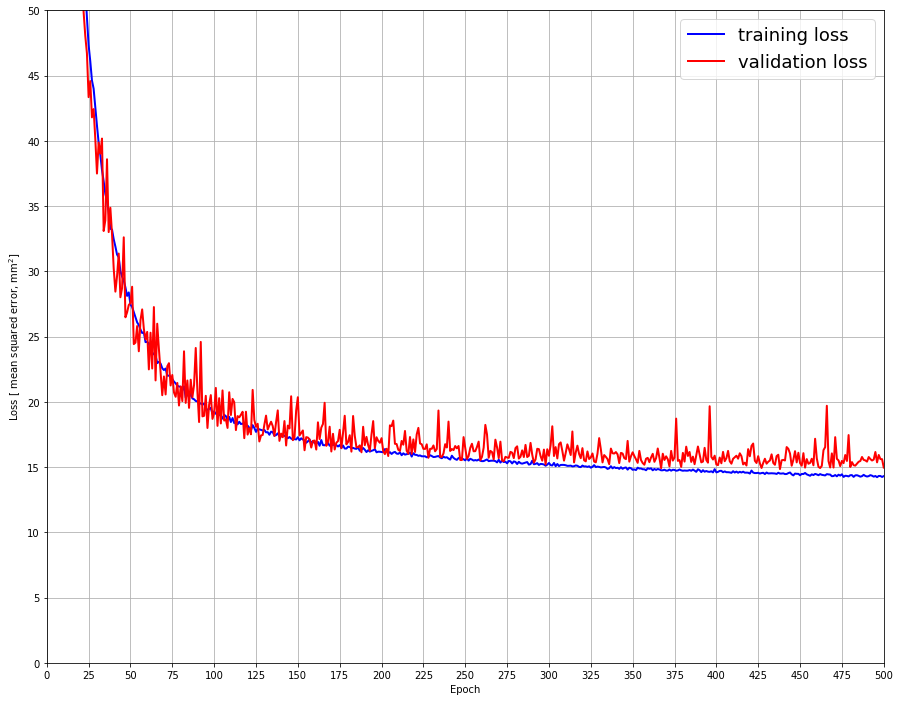

In [94]:
if True:
    x = np.linspace(1, epochs, epochs)
    x = np.linspace(1,len(hist.history['loss']),len(hist.history['loss']))
    val_loss = hist.history['val_loss']
    loss = hist.history['loss']

    fig_sig= plt.figure(figsize = (15,12), facecolor="w")

    #--------------------------------------------------------------------->
    plt.plot(x,loss,label='training loss', color='blue', linestyle = '-', lw=2)
    plt.plot(x,val_loss,label='validation loss', color='red', linestyle = '-', lw=2)
    #-------------------------------------------------------------------->
    # plt.title(r'Fig 3: Training Process', fontsize = 20)
    plt.xlim(0,epochs)
    plt.ylim(0, 50)

    plt.xlabel('Epoch')
    plt.ylabel('Loss [ mean squared error, mm${}^2$]')
    plt.grid(True)

    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    plt.yticks(np.linspace(0,50,11))
    #plt.yticks(np.linspace(0,200,11))

    plt.xticks(np.linspace(0, epochs, int(np.ceil(epochs/25 + 1))) )
    #plt.xticks(np.linspace(0,300,31))
    legend = plt.legend(loc='upper right',fontsize=18)
    #plt.show()
    #fig_sig.savefig(savefname.replace(".hdf5", ".png"))

In [20]:
colormap = deepcopy(cm.YlGn)
colormap.set_under("w")

def plot_dw_pattern(pattern, cmap = "cm.YlGn"):

    xedges = np.linspace(-0.5, pattern.shape[0]-0.5, pattern.shape[0]+1)
    yedges = np.linspace(-0.5, pattern.shape[1]-0.5, pattern.shape[1]+1)
    fig = plt.figure(figsize=(12,8), facecolor = "w")
    ax = fig.add_axes([0.08, 0.08, 0.85, 0.85])
    ax.set_xlim(xedges[0], xedges[-1])
    ax.set_ylim(yedges[0], yedges[-1])
    ax.set_xticks(xedges[0:-1]+0.5)
    ax.set_yticks(yedges[0:-1]+0.5)

    ax.vlines(xedges, ymin=yedges.min(), ymax=yedges.max(), 
              linestyles ="dashed", color = "0.5", linewidth=1)
    ax.hlines(yedges, xmin=xedges.min(), xmax=xedges.max(), 
              linestyles ="dashed", color = "0.5", linewidth=1)

    cvals = ax.pcolor(xedges, yedges, pattern.T,cmap = colormap, vmin=1e-10, vmax=2)
    cbar_ax = fig.add_axes([0.945,0.08,0.035,0.85])
    cbar_bottom = plt.colorbar(cvals, cax = cbar_ax)
    coords = converter.get_coordinates()
    for i in range(0, 253):
        ax.text( coords[i][0],coords[i][1],"%d"%i, va="center", ha="center", fontsize=8)
    ax.set_xlabel("Column X")
    ax.set_ylabel("Row Y")
    return fig, ax, cbar_ax

In [221]:
model_loaded = keras.models.load_model(savefname, custom_objects={"ConvHex": ConvHex})

In [222]:
pred_pos = model_loaded.predict(patterns_test)

Average error is [1.33094735 2.8066643 ]
RMS:  [17.55342716 17.39302385]


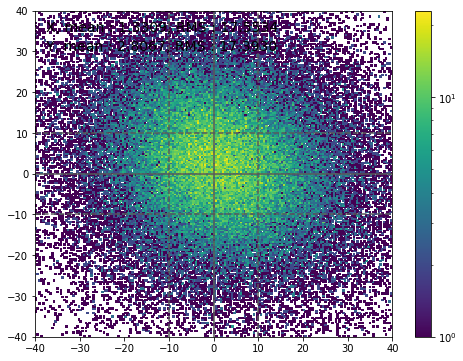

In [223]:
if True:
    plt.figure(figsize = (8,6))
    plt.hist2d(test_pos[:,0]-pred_pos[:,0], test_pos[:,1]-pred_pos[:,1], norm=matplotlib.colors.LogNorm(),
               range=((-40, 40), (-40, 40)),bins=(200, 200))
    plt.colorbar()

    plt.axvline(0, color='black', linestyle='-', linewidth = 1.5, c= "0.35")
    plt.axvline(-10, color='black', linestyle='--', linewidth = 1.5, c= "0.35")
    plt.axvline(10, color='black', linestyle='--', linewidth = 1.5, c= "0.35")

    plt.axhline(0, color='black', linestyle='-', linewidth = 1.5, c= "0.35")
    plt.axhline(-10, color='black', linestyle='--', linewidth = 1.5, c= "0.35")
    plt.axhline(10, color='black', linestyle='--', linewidth = 1.5, c= "0.35")
    bias = np.sum(test_pos-pred_pos,axis = 0) / len(test_pos)
    rms = np.std(test_pos-pred_pos,axis = 0)
    print("Average error is",bias)
    print("RMS: ", rms)
    plt.text(0.03,0.95,"X, mean : %0.4f, RMS : %0.4f"%(bias[0],rms[0] ), 
             transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=14)
    plt.text(0.03,0.89,"Y, mean : %0.4f, RMS : %0.4f"%(bias[1],rms[1] ), 
             transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=14)
    #plt.savefig(savefname.replace(".hdf5", "_XY.png"))

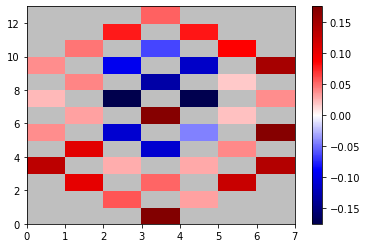

In [24]:
kernels = conv_2D_layer_0.get_kernels()
colormap = deepcopy(cm.seismic)
colormap.set_under("0.75")
cur_kern = np.array(kernels[:,:,0,0])
vscale= abs(cur_kern).max()
cur_kern[cur_kern==0] = -vscale-10
plt.pcolor(cur_kern,cmap=colormap,vmin=-vscale,vmax=vscale) 
plt.colorbar()